# Step 5: Instrument broadening and resampling

We now apply the fifth and final step of the model creation process: applying **instrumental modulation**.  

We will first apply steps 1, 2, 3, and 4 to form a joint model for both the star and telluric atmosphere.  Then we apply an instrumental model layer.

In [1]:
import torch
from blase.emulator import (SparseLinearEmulator, SparseLogEmulator, 
                            ExtrinsicModel, InstrumentalModel)
from blase.utils import doppler_grid
import matplotlib.pyplot as plt
import math
%config InlineBackend.figure_format='retina'

In [2]:
wl_lo = 11_000-60
wl_hi = 11_180+60
wavelength_grid = doppler_grid(wl_lo, wl_hi)

In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

### Apply Steps 1, 2, 3, and 4 to get the flux entering the telescope

We will copy the code verbatim from last time for clarity.

**Step 1:** Clone the stellar spectrum

In [4]:
stellar_pretrained_model = torch.load('phoenix_clone_T4700g4p5_prom0p01_11000Ang.pt')
stellar_emulator = SparseLinearEmulator(wavelength_grid, 
                                        init_state_dict=stellar_pretrained_model)
stellar_emulator.radial_velocity.data = torch.tensor(+25.1)
stellar_emulator.to(device)

Initializing a sparse model with 426 spectral lines


SparseLinearEmulator()

**Step 2:** Clone the Earth's atmosphere spectrum

In [5]:
telluric_pretrained_model = torch.load('telfit_clone_temp290_hum040_prom0p01_11000Ang.pt')
telluric_emulator = SparseLogEmulator(wavelength_grid, 
                                        init_state_dict=telluric_pretrained_model)
telluric_emulator.to(device)

Initializing a sparse model with 265 spectral lines


SparseLogEmulator()

**Step 3:** Apply $v\sin{i}$ broadening and RV shifting

In [6]:
extrinsic_layer = ExtrinsicModel(wavelength_grid, device=device)
vsini = torch.tensor(1.1)
extrinsic_layer.ln_vsini.data = torch.log(vsini)
extrinsic_layer.to(device)

ExtrinsicModel()

*Forward model* Steps 1$-$3.

In [7]:
stellar_flux = stellar_emulator.forward()
broadened_flux = extrinsic_layer(stellar_flux)
telluric_attenuation = telluric_emulator.forward()

**Step 4:** Jointly model the star emergent spectrum and Earth's attenuation.

In [8]:
flux_at_telescope = broadened_flux * telluric_attenuation 

We now move the fifth and final step...

### Philosophical Aside: Instrumental effects
by gully

Every spectrograph is characterized by a finite resolving power, $R\equiv \frac{\lambda}{\delta \lambda}$.  In the pathological limit of *inifite* resolving power $\lim_{R\to \infty}$ the spectrum recorded at the detector would identically resemble the flux coming into the telescope.  This unvarnished spectrum would possess no trace that the spectrum had interacted with a measurement aparatus.  

Instead, **real instruments conduct Acts of Destruction**.  Here is a partial list:

1. Blur the spectrum in a characteristic and predictable way
2. Integrate and resample the spectrum onto discrete pixel coordinates.
3. Warp spectral shapes based on wavelength dependent losses and throughputs
4. Add detector noise

`blasé` currently models Acts 1, 2, and 3 in the `InstrumentalModel` class.  The detector noise gets handled later in likelihood-based inference.

#### Instrumental Blurring
A common heuristic is that the character of the blurring process is roughly Gaussian, with a fixed [FWHM](https://en.wikipedia.org/wiki/Full_width_at_half_maximum) $\approx \frac{\bar\lambda}{\bar R}$ across a limited bandwidth.  Such heuristics appear adequate for most purposes, and so we adopt them here.  These assumptions are imprecise at the high signal-to-noise ratio and large bandwidths of modern spectrographs, though, and we here at *blasé* aspire one day to push the envelope on the extent to which subtle instrumental modulations could be built into this step.

#### Resampling
`blasé` does one slightly non-standard step in the resampling process.  Rather than accept a list of pixel center coordinates, we demand that the user provide the list of pixel **bin edges**.  For most applications, these can be arrived upon by simply assuming an average pixel width $w$ and placing the pixel edges at $\pm \frac{w}{2}$.  But in other cases the bin edges are unevenly spaced, or there may be gaps between pixels.  `blasé` specifically anticipates a future in which this information is more widely available.  Luckily, [specutils](https://specutils.readthedocs.io/en/stable/) already provides an easy-to-use attribute `bin_edges` to input these non-standard coordinates.

Let's fetch some HPF data to get a demo with real-world bin edges.

In [9]:
from muler.hpf import HPFSpectrum

In [10]:
path = 'https://github.com/OttoStruve/muler_example_data/raw/main/HPF/01_A0V_standards/'
filename = 'Goldilocks_20210801T083618_v1.0_0036.spectra.fits'
raw_spectrum = HPFSpectrum(file = path+filename, order=20)

data = raw_spectrum.remove_nans().trim_edges().sky_subtract()

Notice that the bin_edges have [one more element](https://en.wikipedia.org/wiki/Off-by-one_error#Fencepost_error) than the wavelength centers.  A data spectrum with $N$ pixels will have $N+1$ bin edges.

In [11]:
len(data.wavelength), len(data.bin_edges)

(2040, 2041)

**Step 5:** Apply the instrumental broadening and resampling.

In [12]:
instrumental_model = InstrumentalModel(data.bin_edges.value, wavelength_grid)
instrumental_model.to(device)

InstrumentalModel(
  (linear_model): Linear(in_features=15, out_features=1, bias=True)
)

In [13]:
instrumental_model.ln_sigma_angs.data = torch.log(torch.tensor(0.084))

In [14]:
detector_flux = instrumental_model.forward(flux_at_telescope)

We finally have a complete forward model in 5 steps, resulting in our **tunable** prediction for what a data spectrum should look like given all known physical properties.

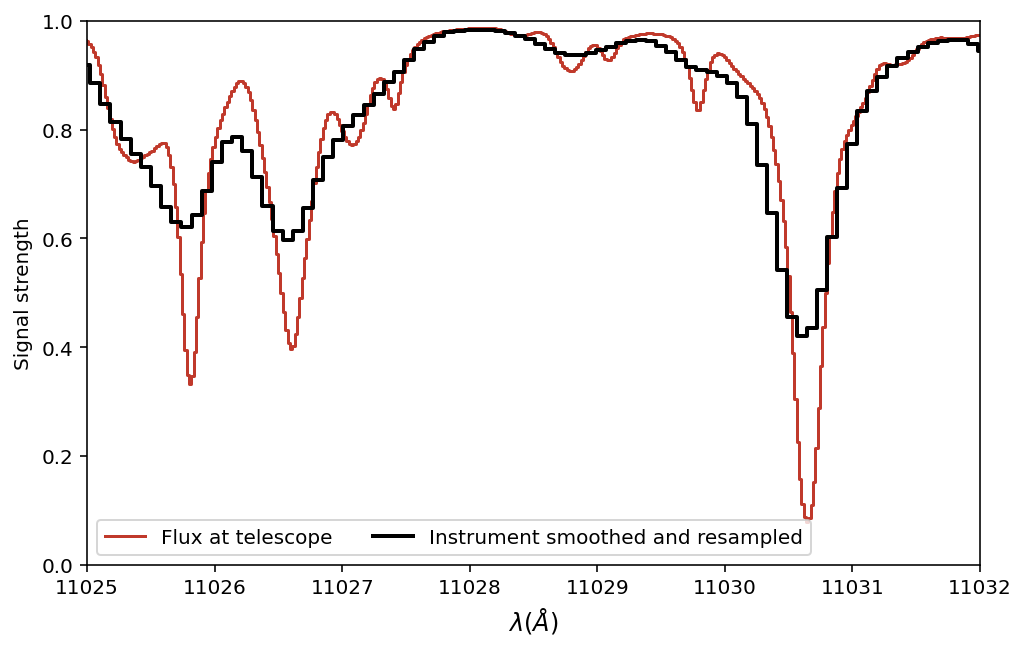

In [15]:
plt.figure(figsize=(8, 5))
plt.step(wavelength_grid, flux_at_telescope.detach().cpu().numpy(), 
         label='Flux at telescope', color='#c0392b')
plt.step(data.wavelength, detector_flux.detach().cpu().numpy(), 
         label='Instrument smoothed and resampled', color='k', lw=2)

plt.xlabel('$\lambda (\AA)$', fontsize=12);plt.ylabel('Signal strength')
plt.xlim(11_025, 11_032); plt.ylim(0, 1.0)
plt.legend(loc='best', ncol=2);

Phew! We have completed all **five steps** to create a forward model for astronomical spectra.  You can see that the instrument-resampled model has much coarser sampling than the underlying input model.

### Next stage: Data-model comparison...
The next stage is to compare this model to real data.  The line properties can then be tuned *en masse* to fit the data spectrum-- awesome!